These are sample codes.

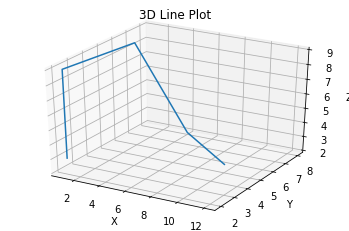

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate example data
data = [
    [1, 2, 3],
    [1, 2, 9],
    [2, 6, 9],
    [4, 8, 2],
    [12, 3, 4]
]

# Plot the line or curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*data))

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Line Plot')

# Show the plot
plt.show()

These are real codes.

In [12]:
import math
import random
import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import itertools

import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
ACTION_SPACE = list(itertools.product([-1, 0, 1], repeat=3))

In [2]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def act(self, obs):
        obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
        q_value = self(obs_tensor.unsqueeze(0))
        max_q_idx = torch.argmax(q_value)
        action = max_q_idx.detach().item()

        return action

In [4]:
class ReplayMemory:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.MEMORY_SIZE = 1000
        self.BATCH_SIZE = 128

        self.all_s = np.empty(shape=(self.MEMORY_SIZE, self.n_states), dtype=np.float32)
        self.all_a = np.random.randint(0, n_actions, size=self.MEMORY_SIZE, dtype=np.uint8)
        self.all_r = np.empty(self.MEMORY_SIZE, dtype=np.float32)
        self.all_done = np.random.randint(0, 2, size=self.MEMORY_SIZE, dtype=np.uint8)
        self.all_ns = np.empty(shape=(self.MEMORY_SIZE, self.n_states), dtype=np.float32)
        self.t_memo = 0
        self.t_max = 0

    def push(self, s, a, r, done, ns):
        self.all_s[self.t_memo] = s
        self.all_a[self.t_memo] = a
        self.all_r[self.t_memo] = r
        self.all_done[self.t_memo] = done
        self.all_ns[self.t_memo] = ns
        self.t_max = max(self.t_max, self.t_memo + 1)
        self.t_memo = (self.t_memo + 1) % self.MEMORY_SIZE

    def sample(self):
        if self.t_max >= self.BATCH_SIZE:
            idx = random.sample(range(0, self.t_max), self.BATCH_SIZE)
        else:
            idx = range(0, self.t_max)

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_ns = []

        for i in idx:
            batch_s.append(self.all_s[i])
            batch_a.append(self.all_a[i])
            batch_r.append(self.all_r[i])
            batch_done.append(self.all_done[i])
            batch_ns.append(self.all_ns[i])

        batch_s_tensor = torch.as_tensor(np.asarray(batch_s), dtype=torch.float32).to(device)
        batch_a_tensor = torch.as_tensor(np.asarray(batch_a), dtype=torch.int64).unsqueeze(-1).to(device)
        batch_r_tensor = torch.as_tensor(np.asarray(batch_r), dtype=torch.float32).to(device)
        batch_done_tensor = torch.as_tensor(np.asarray(batch_done), dtype=torch.int64).unsqueeze(-1).to(device)
        batch_ns_tensor = torch.as_tensor(np.asarray(batch_ns), dtype=torch.float32).to(device)

        return batch_s_tensor, batch_a_tensor, batch_r_tensor, batch_done_tensor, batch_ns_tensor

In [ ]:
class Env:

    def __init__(self):
        # Current trajectory, python list is used here instead of nmupy array, because it has faster append
        # Currently the dimension is 6, (x,y,z) position and (xd, yd, zd) as velocity
        self.traj_cur = [[0, 0, 0, 0, 0, 0]]

         # The new point that will be appended to the trajectory
        self.new_point = [0, 0, 0, 0, 0, 0]

        self.up_limit = np.array([1, 1, 1, 0.1, 0.1, 0.1]) # The upper limit of all dimension
        self.low_limit = np.array([-1, -1, -1, -0.1, -0.1, -0.1]) # The lower limit of all dimension
        self.dt = 0.1 # This is the delta time between iterations

        self.time_limit = 360   # 3600 sec, 1 hour
        self.step_limit = self.time_limit / self.dt
        self.step_count = 0

    # This takes action (ax, ay, az) as input and iterate the trajectory for one more step and then compute the reward
    def step(self, action):
        last_point = self.traj_cur[-1]

        action = ACTION_SPACE[action]

        # update velocity
        self.new_point[3] = last_point[3] + self.dt * action[0]
        self.new_point[4] = last_point[4] + self.dt * action[1]
        self.new_point[5] = last_point[5] + self.dt * action[2]

        # update position
        self.new_point[0] = last_point[0] + self.dt * self.new_point[3]
        self.new_point[1] = last_point[1] + self.dt * self.new_point[4]
        self.new_point[2] = last_point[2] + self.dt * self.new_point[5]

        self.step_count += 1

        self.traj_cur.append(self.new_point)

        # check the limit, if so, return negative reward and end sign as true
        done = False
        idx_exd_max, idx_exd_min = self.__check_limit()
        if idx_exd_max.size != 0 or idx_exd_min.size != 0:
            #print('New point outside limit')
            #print('New point:')
            #print(self.new_point)
            #print('index exceed UPPER limit:')
            #print(idx_exd_max)
            #print('index exceed LOWER limit:')
            #print(idx_exd_min)
            reward = -1 # Negative reward as penalty
            done = True
            return self.new_point, reward, done

        # compute reward if limit check is passed
        reward = np.sum(np.var(np.array(self.traj_cur), axis=0)) # This is a very rough reward, based on variance, we need a better one

        # end = True if reach step limit
        if self.step_count >= self.step_limit:
            done = True
        else:
            done = False

        return self.new_point, reward, done


    def reset(self):
        self.traj_cur = [[0, 0, 0, 0, 0, 0]]
        self.new_point = [0, 0, 0, 0, 0, 0]

        return self.new_point


    def __check_limit(self):
        new_point = np.array(self.new_point)

        diff_max = self.up_limit - new_point
        idx_exd_max = np.array(np.where(diff_max<0))

        diff_min = self.low_limit - new_point
        idx_exd_min = np.array(np.where(diff_min>0))

        return idx_exd_max, idx_exd_min

    # Display the env
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(*zip(*[self.traj_cur[i][:3] for i in range(len(self.traj_cur))]))

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Line Plot')

        # Show the plot
        plt.show()

In [5]:
class Agent:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions

        self.GAMMA = 0.99
        self.LR = 1e-4

        self.memo = ReplayMemory(n_states, n_actions)

        self.policy_net = DQN(self.n_states, self.n_actions).to(device)
        self.target_net = DQN(self.n_states, self.n_actions).to(device)

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)

In [ ]:
env = Env()

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 10

n_episode = 5000
n_time_step = 1000

# number of states needed to describe (P_x,P_y,P_z,V_x,V_y,V_z)
STATE_DIM = 6

# number of actions needed to describe the change in (V_x,V_y,V_z)
ACTION_DIM = 3**3

In [ ]:
agent = Agent(n_states=STATE_DIM, n_actions=ACTION_DIM)

REWARD_BUFFER = np.empty(shape=n_episode)

for episode_i in range(n_episode):
    episode_reward = 0
    state = env.reset()

    for step_i in range(n_time_step):
        eps = np.interp(episode_i * n_time_step + step_i, [0, EPS_DECAY], [EPS_START, EPS_END])
        random_sample = random.random()

        if random_sample <= eps:
            a = random.randint(0, agent.n_actions-1)
        else:
            a = agent.policy_net.act(state)

        next_state, r, done = env.step(a)

        agent.memo.push(state, a, r, done, next_state)

        state = next_state
        episode_reward += r

        if done:
            print("Done:")
            print(env.traj_cur)
            state = env.reset()
            REWARD_BUFFER[episode_i] = episode_reward
            break

        if np.mean(REWARD_BUFFER[:episode_i]) >= 100:
            while True:
                a = agent.policy_net.act(state)
                next_state, r, done = env.step(a)
                env.render()

                if done:
                    env.reset()

        batch_s, batch_a, batch_r, batch_done, batch_ns = agent.memo.sample()

        # Compute targets
        target_q_values = agent.target_net(batch_ns)
        target_max_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = batch_r + agent.GAMMA * (1-batch_done) * target_max_q_values

        # Compute q_values
        q_values = agent.policy_net(batch_s)
        a_q_values = torch.gather(input=q_values, dim=1, index=batch_a)

        # Compute loss
        loss = F.smooth_l1_loss(targets, a_q_values)

        # Graident descent
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step()

    if episode_i % TAU == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

        print("Episode: {}".format(episode_i))
        print("Average reward: {}".format(np.mean(REWARD_BUFFER[:episode_i])))